# Question 2b: Same Question Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import defaultdict
import pickle

#sklearn libraries
import sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words as sk_sw

from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test_without_labels.csv")

In [3]:
train_dataset.dropna(inplace = True)

In [4]:
#Function to calculate normalized word share between two questions
#Equation: {(Common Length of two questions (Shortest Length among the two questions)) / 
#                    ((Length of Question 1) + (Length of Question 2))}
def word_share(x):
    word_1 = set(map(lambda word: word.lower().strip(), str(x['Question1']).split(" ")))
    word_2 = set(map(lambda word: word.lower().strip(), str(x['Question2']).split(" ")))
    return 1.0 * len(word_1 & word_2)/(len(word_1) + len(word_2))

In [5]:
#Function to calculate TF-IDF word share between two questions
def tfidf_word_share(x):    
    count_vectorizer = CountVectorizer()
    document = []
    document.append(str(x['Question1']))
    document.append(str(x['Question2']))
    freq_term_matrix = count_vectorizer.fit_transform(document)
    tfidf = TfidfTransformer(norm = "l2")
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix_1 = tfidf.transform(freq_term_matrix)
    arr = cosine_similarity(tf_idf_matrix_1[0:1], tf_idf_matrix_1)
    return arr[0][1]

In [6]:
"""
Features Construction:
1. length
2. number of words
3. word share 
4. tf-idf word share
""" 
new_train_dataset = pd.DataFrame(dtype='float64')
new_train_dataset['q1_length'] = train_dataset['Question1'].str.len()   # Length of the question 1
new_train_dataset['q2_length'] = train_dataset['Question2'].str.len()   # Length of the question 2
new_train_dataset['q1_words_num'] = train_dataset['Question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_train_dataset['q2_words_num'] = train_dataset['Question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_train_dataset['word_share'] = train_dataset.apply(word_share, axis=1) # Calculating word share between the two questions
new_train_dataset['TFIDF_share'] = train_dataset.apply(tfidf_word_share, axis=1, raw=True) # Calculating the tf-tdf word share between the two questions

In [7]:
"""
Features Construction:
1. length
2. number of words
3. word share 
4. tf-idf word share
""" 
new_test_dataset = pd.DataFrame(dtype='float64')
new_test_dataset['q1_length'] = test_dataset['Question1'].str.len()   # Length of the question 1
new_test_dataset['q2_length'] = test_dataset['Question2'].str.len()   # Length of the question 2
new_test_dataset['q1_words_num'] = test_dataset['Question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_test_dataset['q2_words_num'] = test_dataset['Question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_test_dataset['word_share'] = test_dataset.apply(word_share, axis=1) # Calculating word share between the two questions
new_test_dataset['TFIDF_share'] = test_dataset.apply(tfidf_word_share, axis=1, raw=True) # Calculating the tf-tdf word share between the two questions

In [8]:
new_train_dataset.head()

,q1_length,q2_length,q1_words_num,q2_words_num,word_share,TFIDF_share
0,66,57,14,12,0.434783,0.920307
1,51,88,8,13,0.200000,0.424251
2,73,59,14,10,0.166667,0.225765
3,50,65,11,9,0.000000,0.000000
4,76,39,13,7,0.100000,0.272060


In [9]:
new_test_dataset.head()

,q1_length,q2_length,q1_words_num,q2_words_num,word_share,TFIDF_share
0,100.0,77,17,18,0.176471,0.262366
1,39.0,48,7,8,0.133333,0.253209
2,46.0,37,10,8,0.333333,0.615219
3,113.0,121,18,18,0.444444,0.820021
4,148.0,48,29,9,0.081081,0.073565


In [10]:
# Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(new_train_dataset))
new_train_dataset.loc[:,['q2_length','q1_length','word_share','TFIDF_share']] = np.nan_to_num(
        new_train_dataset.loc[:,['q2_length','q1_length' ,'word_share','TFIDF_share']])
np.sum(np.isnan(new_train_dataset))

q1_length       0
q2_length       0
q1_words_num    0
q2_words_num    0
word_share      0
TFIDF_share     0
dtype: int64

In [11]:
# Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(new_test_dataset))
new_test_dataset.loc[:,['q2_length','q1_length','word_share','TFIDF_share']] = np.nan_to_num(
        new_test_dataset.loc[:,['q2_length','q1_length' ,'word_share','TFIDF_share']])
np.sum(np.isnan(new_test_dataset))

q1_length       0
q2_length       0
q1_words_num    0
q2_words_num    0
word_share      0
TFIDF_share     0
dtype: int64

Text(0.5, 0, 'Word Share')

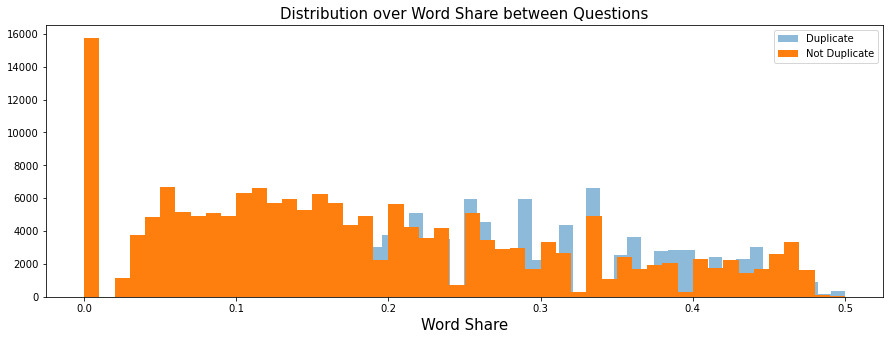

In [12]:
plt.figure(figsize=(15, 5))
plot_word_share = new_train_dataset['word_share']
plt.hist(plot_word_share[train_dataset['IsDuplicate'] == 1], bins = 50, alpha = 0.5, label='Duplicate')
plt.hist(plot_word_share[train_dataset['IsDuplicate'] == 0], bins = 50, label = 'Not Duplicate')
plt.legend()
plt.title('Distribution over Word Share between Questions', fontsize = 15)
plt.xlabel('Word Share', fontsize = 15)

Text(0.5, 0, 'TFIDF Share')

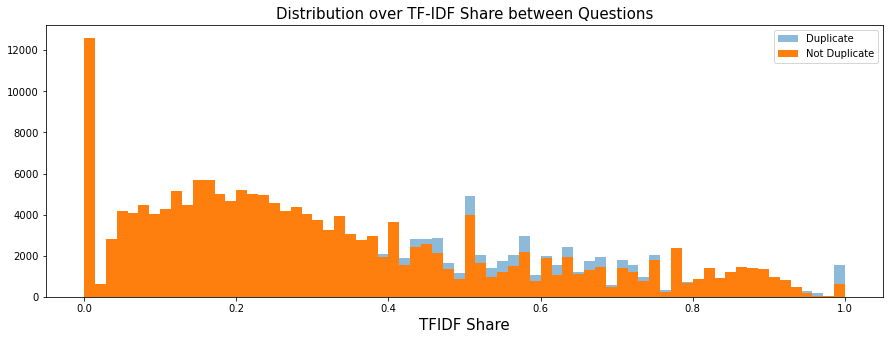

In [13]:
# Visualisation based on the feature : TF-IDF Word Share
plt.figure(figsize=(15, 5))
plot_tfidf_share = new_train_dataset['TFIDF_share']
plt.hist(plot_tfidf_share[train_dataset['IsDuplicate'] == 1], bins = 70, alpha = 0.5, label='Duplicate')
plt.hist(plot_tfidf_share[train_dataset['IsDuplicate'] == 0], bins = 70, label = 'Not Duplicate')
plt.legend()
plt.title('Distribution over TF-IDF Share between Questions', fontsize = 15)
plt.xlabel('TFIDF Share', fontsize = 15)

### Normalizing the dataset

In [14]:
# Normalized feature values
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
new_train_dataset_scaled = scaler.fit_transform(new_train_dataset)
new_test_dataset_scaled = scaler.fit_transform(new_test_dataset)

 ### Split the model into Train and Test Dataset 

In [15]:
label = train_dataset['IsDuplicate']   # Target Set
X_train, X_test, y_train, y_test = train_test_split(new_train_dataset_scaled, label, test_size = 0.3, random_state = 0)

In [16]:
label = label.to_numpy()

### Method-1: Random Forest 

In [17]:
# Model 1:  Random forest
RFClas = RandomForestClassifier(n_estimators = 100)
RFClas.fit(X_train, y_train)

predictions_RF = RFClas.predict(X_test)

print("Logistic Regression - Prediction:", predictions_RF)

Logistic Regression - Prediction: [0 0 1 ... 1 0 0]


In [18]:
kfold = KFold(n_splits = 5)

for train_index, test_index in kfold.split(new_train_dataset_scaled, label):
    clf_cv = RFClas.fit(new_train_dataset_scaled[train_index], label[train_index])
    yPred = clf_cv.predict(new_train_dataset_scaled[test_index])
    yTrue = np.array(label)[test_index]
    print("\t\tClassification Report")
    print(classification_report(yTrue, yPred))

		Classification Report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     35456
           1       0.61      0.61      0.61     21145

    accuracy                           0.71     56601
   macro avg       0.69      0.69      0.69     56601
weighted avg       0.71      0.71      0.71     56601

		Classification Report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     35674
           1       0.61      0.61      0.61     20927

    accuracy                           0.71     56601
   macro avg       0.69      0.69      0.69     56601
weighted avg       0.71      0.71      0.71     56601

		Classification Report
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     35431
           1       0.61      0.60      0.60     21169

    accuracy                           0.71     56600
   macro avg       0.69      0.69      0.69     56600
we

### Method-2: Logistic Regression

In [19]:
# Model 2: Logistic Regression
LRClas = LogisticRegression()
LRClas.fit (X_train, y_train)
prediction_LR = LRClas.predict(X_train)
print("Logistic Regression - Prediction:", prediction_LR)

Logistic Regression - Prediction: [0 0 0 ... 0 0 0]


In [20]:
kfold = KFold(n_splits = 5)

for train_index, test_index in kfold.split(new_train_dataset_scaled, label):
    clf_cv = LRClas.fit(new_train_dataset_scaled[train_index], label[train_index])
    yPred = clf_cv.predict(new_train_dataset_scaled[test_index])
    yTrue = np.array(label)[test_index]
    print("\t\tClassification Report")
    print(classification_report(yTrue, yPred))

		Classification Report
              precision    recall  f1-score   support

           0       0.71      0.79      0.74     35456
           1       0.56      0.46      0.50     21145

    accuracy                           0.66     56601
   macro avg       0.63      0.62      0.62     56601
weighted avg       0.65      0.66      0.65     56601

		Classification Report
              precision    recall  f1-score   support

           0       0.71      0.78      0.75     35674
           1       0.56      0.46      0.50     20927

    accuracy                           0.66     56601
   macro avg       0.63      0.62      0.62     56601
weighted avg       0.65      0.66      0.66     56601

		Classification Report
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     35431
           1       0.55      0.45      0.50     21169

    accuracy                           0.66     56600
   macro avg       0.63      0.62      0.62     56600
we

### Saving Test set predictions

In [21]:
predictions_RF_test = RFClas.predict(new_test_dataset_scaled)

In [22]:
predictions_RF_test

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [23]:
id_n = test_dataset['Id']

prediction_table = pd.DataFrame(data = id_n, columns = ['Id'])
prediction_table['Expected'] = predictions_RF_test

In [24]:
prediction_table.to_csv('duplicate_predictions.csv', sep = ',', index = False)